In [1]:
%matplotlib inline
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
import seaborn as sn
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils.np_utils import to_categorical
from itertools import combinations 

In [2]:
df_train = pd.read_csv('forest-cover-type-prediction/train.csv')
df_train.sample(5)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
7091,7092,2695,131,16,350,11,1541,244,230,109,...,0,0,0,0,0,0,0,0,0,3
10027,10028,3300,114,5,0,0,1879,228,235,141,...,0,0,0,0,0,0,0,1,0,7
3935,3936,2322,45,15,285,98,1127,223,206,113,...,0,0,0,0,0,0,0,0,0,3
11465,11466,2933,75,8,540,-5,3998,230,225,127,...,0,0,0,0,0,0,0,0,0,2
4623,4624,2122,49,24,0,0,309,221,180,80,...,0,0,0,0,0,0,0,0,0,4


## Data Transformations

In [3]:
# normalization
from sklearn.preprocessing import normalize

col_normalize = ['Elevation', 'Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Roadways']
df_train_norm = df_train.copy()
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
#df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn import model_selection

In [5]:
np.set_printoptions(precision=5)
def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False):
    X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.13, random_state=0)
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    end = time.time()
    print('\nModel:',type(model).__name__)
    print('\tcv acc:', round(results.mean(),4))
    print('\tsplit acc:', round(acc,4))
    print('\ttime taken:', round(end-start, 4))
    if display:
        matrix = cm(y_val, pred)
        print('\t', matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Id','Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_time:
        return_data += [end-start]
    return tuple(return_data)

# Data filtering to Cat 1 and 2

In [6]:
maska = df_train_norm['Cover_Type']==1
maskb = df_train_norm['Cover_Type']==2
mask = maska | maskb
df_1_2 = df_train_norm[mask]

# Heatmap by sub-selection of highly confounded Cover_Types

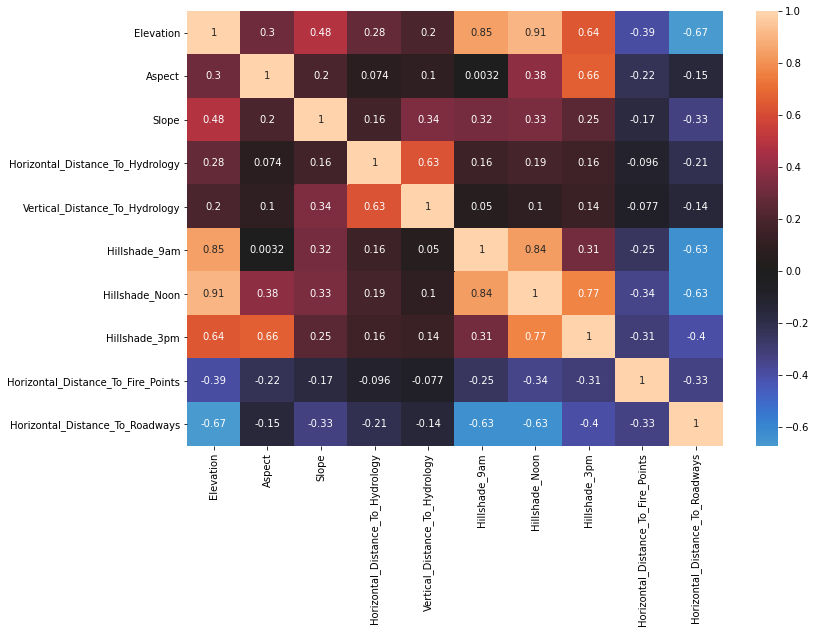

In [7]:
# looking more closely at covers 1 and 2
fig = plt.figure(1, figsize=(12, 8))
small_ab_eda = df_train_norm[mask][col_normalize]
sn.heatmap(small_ab_eda.corr(), annot=True, center=0)

# ExtraTreesClassifier

ExtraTreesClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

# Model for cover_types 1 and 2 only

In [8]:
if False:
    mod_1_2 = score_model(ExtraTreesClassifier(n_jobs=-1, random_state=0),df_1_2)

# Neural Network

In [9]:
X = df_train_norm.iloc[:,1:-1]
y = df_train_norm.iloc[:,-1:]

from keras.utils import np_utils
y_enc = np_utils.to_categorical(y)
y_enc[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [70]:
import tensorflow.keras as keras

def create_model(input_size=54, output_size=8, version=3):
    # create model
    initializer = None #keras.initializers.RandomNormal(mean=0., stddev=1.)
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(input_size,)))

    if version==1:
        model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(32, activation='relu', kernel_initializer=initializer))

    if version==2:
        model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(256, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(64, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(32, activation='relu', kernel_initializer=initializer))

    if version==3:
        model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(256, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dropout(rate=.1))
        model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(64, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dense(32, activation='relu', kernel_initializer=initializer))
        model.add(keras.layers.Dropout(rate=.1))

    model.add(keras.layers.Dense(output_size, activation='softmax', kernel_initializer=initializer))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [71]:
from keras.wrappers.scikit_learn import KerasClassifier

kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X, np.array(y_enc), test_size=.13, random_state=0)

histories = []
for v in [1,2,3]:
    model_val = create_model(version=v)

    start = time.time()
    history = model_val.fit(X_train.values, y_train, batch_size=16, epochs=200, verbose=2, validation_split=0.2)
    histories.append(history)
    
    end = time.time()

    print('\nEnd Model ',v)
    print('\ttime taken:', round(end-start, 4))


Epoch 1/200
658/658 - 1s - loss: 1.0546 - accuracy: 0.5653 - val_loss: 0.9087 - val_accuracy: 0.6123
Epoch 2/200
658/658 - 0s - loss: 0.8877 - accuracy: 0.6160 - val_loss: 0.8846 - val_accuracy: 0.6416
Epoch 3/200
658/658 - 0s - loss: 0.8416 - accuracy: 0.6418 - val_loss: 0.8247 - val_accuracy: 0.6648
Epoch 4/200
658/658 - 0s - loss: 0.8084 - accuracy: 0.6535 - val_loss: 0.8076 - val_accuracy: 0.6655
Epoch 5/200
658/658 - 0s - loss: 0.7847 - accuracy: 0.6644 - val_loss: 0.7735 - val_accuracy: 0.6815
Epoch 6/200
658/658 - 1s - loss: 0.7587 - accuracy: 0.6752 - val_loss: 0.7608 - val_accuracy: 0.6803
Epoch 7/200
658/658 - 0s - loss: 0.7388 - accuracy: 0.6889 - val_loss: 0.7446 - val_accuracy: 0.6815
Epoch 8/200
658/658 - 0s - loss: 0.7208 - accuracy: 0.6915 - val_loss: 0.7549 - val_accuracy: 0.6724
Epoch 9/200
658/658 - 0s - loss: 0.7040 - accuracy: 0.6946 - val_loss: 0.7158 - val_accuracy: 0.6918
Epoch 10/200
658/658 - 0s - loss: 0.6904 - accuracy: 0.7053 - val_loss: 0.7091 - val_accura

Epoch 82/200
658/658 - 0s - loss: 0.3074 - accuracy: 0.8720 - val_loss: 0.5213 - val_accuracy: 0.8202
Epoch 83/200
658/658 - 0s - loss: 0.3019 - accuracy: 0.8738 - val_loss: 0.5173 - val_accuracy: 0.8248
Epoch 84/200
658/658 - 0s - loss: 0.3006 - accuracy: 0.8772 - val_loss: 0.5103 - val_accuracy: 0.8240
Epoch 85/200
658/658 - 0s - loss: 0.2939 - accuracy: 0.8817 - val_loss: 0.5363 - val_accuracy: 0.8138
Epoch 86/200
658/658 - 0s - loss: 0.2895 - accuracy: 0.8822 - val_loss: 0.5091 - val_accuracy: 0.8271
Epoch 87/200
658/658 - 0s - loss: 0.2886 - accuracy: 0.8801 - val_loss: 0.5548 - val_accuracy: 0.8107
Epoch 88/200
658/658 - 0s - loss: 0.2914 - accuracy: 0.8796 - val_loss: 0.4839 - val_accuracy: 0.8415
Epoch 89/200
658/658 - 0s - loss: 0.2919 - accuracy: 0.8823 - val_loss: 0.5059 - val_accuracy: 0.8312
Epoch 90/200
658/658 - 0s - loss: 0.2867 - accuracy: 0.8823 - val_loss: 0.5445 - val_accuracy: 0.8225
Epoch 91/200
658/658 - 0s - loss: 0.2898 - accuracy: 0.8795 - val_loss: 0.5557 - v

Epoch 162/200
658/658 - 0s - loss: 0.1906 - accuracy: 0.9248 - val_loss: 0.6181 - val_accuracy: 0.8453
Epoch 163/200
658/658 - 0s - loss: 0.1922 - accuracy: 0.9206 - val_loss: 0.6528 - val_accuracy: 0.8305
Epoch 164/200
658/658 - 0s - loss: 0.1871 - accuracy: 0.9233 - val_loss: 0.6121 - val_accuracy: 0.8316
Epoch 165/200
658/658 - 0s - loss: 0.1813 - accuracy: 0.9227 - val_loss: 0.6308 - val_accuracy: 0.8392
Epoch 166/200
658/658 - 0s - loss: 0.1832 - accuracy: 0.9241 - val_loss: 0.6112 - val_accuracy: 0.8396
Epoch 167/200
658/658 - 0s - loss: 0.1804 - accuracy: 0.9261 - val_loss: 0.6212 - val_accuracy: 0.8320
Epoch 168/200
658/658 - 0s - loss: 0.1890 - accuracy: 0.9214 - val_loss: 0.6432 - val_accuracy: 0.8309
Epoch 169/200
658/658 - 0s - loss: 0.1767 - accuracy: 0.9277 - val_loss: 0.6214 - val_accuracy: 0.8407
Epoch 170/200
658/658 - 0s - loss: 0.1800 - accuracy: 0.9247 - val_loss: 0.5878 - val_accuracy: 0.8502
Epoch 171/200
658/658 - 0s - loss: 0.1795 - accuracy: 0.9254 - val_loss: 

Epoch 42/200
658/658 - 1s - loss: 0.3351 - accuracy: 0.8572 - val_loss: 0.5443 - val_accuracy: 0.8077
Epoch 43/200
658/658 - 1s - loss: 0.3351 - accuracy: 0.8566 - val_loss: 0.5877 - val_accuracy: 0.7925
Epoch 44/200
658/658 - 1s - loss: 0.3335 - accuracy: 0.8605 - val_loss: 0.5392 - val_accuracy: 0.8046
Epoch 45/200
658/658 - 1s - loss: 0.3247 - accuracy: 0.8624 - val_loss: 0.5493 - val_accuracy: 0.8115
Epoch 46/200
658/658 - 1s - loss: 0.3216 - accuracy: 0.8661 - val_loss: 0.5367 - val_accuracy: 0.8096
Epoch 47/200
658/658 - 1s - loss: 0.3135 - accuracy: 0.8659 - val_loss: 0.5602 - val_accuracy: 0.8062
Epoch 48/200
658/658 - 1s - loss: 0.3086 - accuracy: 0.8664 - val_loss: 0.5756 - val_accuracy: 0.7967
Epoch 49/200
658/658 - 1s - loss: 0.3044 - accuracy: 0.8707 - val_loss: 0.5553 - val_accuracy: 0.8100
Epoch 50/200
658/658 - 1s - loss: 0.2978 - accuracy: 0.8730 - val_loss: 0.5808 - val_accuracy: 0.8119
Epoch 51/200
658/658 - 1s - loss: 0.2924 - accuracy: 0.8729 - val_loss: 0.5609 - v

658/658 - 1s - loss: 0.1528 - accuracy: 0.9357 - val_loss: 0.8002 - val_accuracy: 0.8221
Epoch 123/200
658/658 - 1s - loss: 0.1572 - accuracy: 0.9361 - val_loss: 0.7667 - val_accuracy: 0.8282
Epoch 124/200
658/658 - 1s - loss: 0.1382 - accuracy: 0.9436 - val_loss: 0.7769 - val_accuracy: 0.8145
Epoch 125/200
658/658 - 1s - loss: 0.1479 - accuracy: 0.9379 - val_loss: 0.8015 - val_accuracy: 0.8290
Epoch 126/200
658/658 - 1s - loss: 0.1440 - accuracy: 0.9404 - val_loss: 0.7831 - val_accuracy: 0.8290
Epoch 127/200
658/658 - 1s - loss: 0.1409 - accuracy: 0.9413 - val_loss: 0.8046 - val_accuracy: 0.8236
Epoch 128/200
658/658 - 1s - loss: 0.1579 - accuracy: 0.9349 - val_loss: 0.7860 - val_accuracy: 0.8206
Epoch 129/200
658/658 - 1s - loss: 0.1402 - accuracy: 0.9446 - val_loss: 0.8085 - val_accuracy: 0.8320
Epoch 130/200
658/658 - 1s - loss: 0.1527 - accuracy: 0.9373 - val_loss: 0.7606 - val_accuracy: 0.8290
Epoch 131/200
658/658 - 1s - loss: 0.1434 - accuracy: 0.9406 - val_loss: 0.7739 - val_a

Epoch 2/200
658/658 - 1s - loss: 0.9406 - accuracy: 0.5975 - val_loss: 0.8963 - val_accuracy: 0.6275
Epoch 3/200
658/658 - 1s - loss: 0.8770 - accuracy: 0.6257 - val_loss: 0.8253 - val_accuracy: 0.6621
Epoch 4/200
658/658 - 1s - loss: 0.8321 - accuracy: 0.6508 - val_loss: 0.8033 - val_accuracy: 0.6762
Epoch 5/200
658/658 - 1s - loss: 0.7985 - accuracy: 0.6608 - val_loss: 0.7781 - val_accuracy: 0.6606
Epoch 6/200
658/658 - 1s - loss: 0.7713 - accuracy: 0.6687 - val_loss: 0.7619 - val_accuracy: 0.6712
Epoch 7/200
658/658 - 1s - loss: 0.7381 - accuracy: 0.6927 - val_loss: 0.7324 - val_accuracy: 0.6940
Epoch 8/200
658/658 - 1s - loss: 0.7196 - accuracy: 0.6987 - val_loss: 0.7183 - val_accuracy: 0.7024
Epoch 9/200
658/658 - 1s - loss: 0.6942 - accuracy: 0.7085 - val_loss: 0.7041 - val_accuracy: 0.6986
Epoch 10/200
658/658 - 1s - loss: 0.6793 - accuracy: 0.7122 - val_loss: 0.6851 - val_accuracy: 0.7024
Epoch 11/200
658/658 - 1s - loss: 0.6608 - accuracy: 0.7242 - val_loss: 0.6476 - val_accur

Epoch 83/200
658/658 - 1s - loss: 0.3029 - accuracy: 0.8682 - val_loss: 0.5826 - val_accuracy: 0.8172
Epoch 84/200
658/658 - 1s - loss: 0.2938 - accuracy: 0.8765 - val_loss: 0.5947 - val_accuracy: 0.8164
Epoch 85/200
658/658 - 1s - loss: 0.2829 - accuracy: 0.8775 - val_loss: 0.6061 - val_accuracy: 0.8107
Epoch 86/200
658/658 - 1s - loss: 0.2975 - accuracy: 0.8747 - val_loss: 0.6096 - val_accuracy: 0.8160
Epoch 87/200
658/658 - 1s - loss: 0.2848 - accuracy: 0.8771 - val_loss: 0.6222 - val_accuracy: 0.8149
Epoch 88/200
658/658 - 1s - loss: 0.2861 - accuracy: 0.8789 - val_loss: 0.5938 - val_accuracy: 0.8187
Epoch 89/200
658/658 - 1s - loss: 0.2827 - accuracy: 0.8778 - val_loss: 0.6058 - val_accuracy: 0.8214
Epoch 90/200
658/658 - 1s - loss: 0.2825 - accuracy: 0.8796 - val_loss: 0.6241 - val_accuracy: 0.8122
Epoch 91/200
658/658 - 1s - loss: 0.2843 - accuracy: 0.8785 - val_loss: 0.6242 - val_accuracy: 0.8149
Epoch 92/200
658/658 - 1s - loss: 0.2827 - accuracy: 0.8769 - val_loss: 0.6356 - v

Epoch 163/200
658/658 - 1s - loss: 0.1962 - accuracy: 0.9182 - val_loss: 0.7079 - val_accuracy: 0.8312
Epoch 164/200
658/658 - 1s - loss: 0.1919 - accuracy: 0.9187 - val_loss: 0.7565 - val_accuracy: 0.8172
Epoch 165/200
658/658 - 1s - loss: 0.1833 - accuracy: 0.9216 - val_loss: 0.7684 - val_accuracy: 0.8271
Epoch 166/200
658/658 - 1s - loss: 0.1985 - accuracy: 0.9184 - val_loss: 0.7458 - val_accuracy: 0.8210
Epoch 167/200
658/658 - 1s - loss: 0.2045 - accuracy: 0.9158 - val_loss: 0.7253 - val_accuracy: 0.8331
Epoch 168/200
658/658 - 1s - loss: 0.1946 - accuracy: 0.9164 - val_loss: 0.7132 - val_accuracy: 0.8324
Epoch 169/200
658/658 - 1s - loss: 0.1978 - accuracy: 0.9175 - val_loss: 0.7731 - val_accuracy: 0.8206
Epoch 170/200
658/658 - 1s - loss: 0.1837 - accuracy: 0.9226 - val_loss: 0.7855 - val_accuracy: 0.8271
Epoch 171/200
658/658 - 1s - loss: 0.1924 - accuracy: 0.9185 - val_loss: 0.7566 - val_accuracy: 0.8225
Epoch 172/200
658/658 - 1s - loss: 0.2050 - accuracy: 0.9175 - val_loss: 

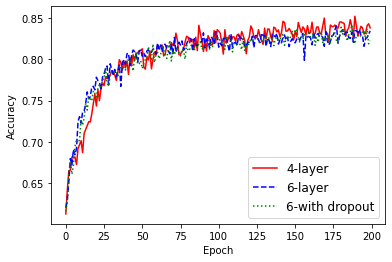

In [72]:
fig, ax = plt.subplots()

for hist, tint, styl, labl in zip(histories, 
                                  ['red','blue','green'], 
                                  ['solid','dashed','dotted'],
                                  ['4-layer','6-layer','6-with dropout']):
    ax.plot(hist.history['val_accuracy'], color=tint, linestyle=styl, label=labl)

ax.legend(loc='lower right', fontsize='large')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [73]:
max(histories[0].history['val_accuracy'])

0.8525275588035583

In [20]:
#!pip3 install keras-visualizer

In [57]:
from keras.utils.vis_utils import plot_model, model_to_dot
print_model = create_model(version=1)
plot_model(print_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from keras_visualizer import visualizer
visualizer(print_model, format='png', view=True)

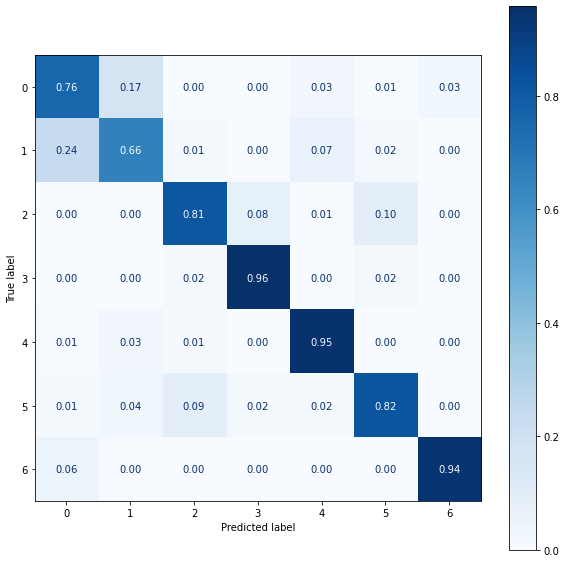

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(np.argmax(y_val, axis=1), pred, normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
obj_classes_desc = [str(i) for i in range(0,8)]
cm_disp = ConfusionMatrixDisplay(cm, display_labels=obj_classes_desc)
cm_disp.plot(values_format='.2f', ax=ax, cmap='Blues')

# Modeling for Types 1 and 2 only:  Did not change result

In [ ]:
if False:
    X_1_2 = df_1_2.iloc[:,1:-1]
    y_1_2 = df_1_2.iloc[:,-1:]

    from keras.utils import np_utils
    y_1_2_enc = np_utils.to_categorical(y_1_2)

    model_1_2 = create_model(X_1_2.shape[1], y_1_2_enc.shape[1])
    history = model_1_2.fit(X_1_2.values, y_1_2_enc, 
                          batch_size=32, epochs=300, 
                          verbose=2, validation_split=0.2)

In [ ]:
if False:
    y_1_2_pred = model.predict(X_1_2.values)
    y_1_2_pred = np.argmax(y_1_2_pred, axis=1)+1

    cm_1_2 = confusion_matrix(y_1_2, y_1_2_pred, normalize='true')

    fig, ax = plt.subplots(figsize=(10, 10))
    obj_classes_desc = [str(i) for i in range(0,3)]
    cm_1_2_disp = ConfusionMatrixDisplay(cm_1_2, display_labels=obj_classes_desc)
    cm_1_2_disp.plot(values_format='.2f', ax=ax, cmap='Blues')

In [ ]:
if False:
    model_eval = model_1_2.evaluate(X_1_2.values, y_1_2_enc, return_dict=True)

# Shap analysis for full model

In [ ]:
import tensorflow as tf 
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
import keras

In [ ]:
model_shap = create_model(X.shape[1], y_enc.shape[1])
history_shap = model_shap.fit(X.values, y_enc, 
                      batch_size=32, epochs=300, 
                      verbose=0, validation_split=0.2)

In [ ]:
import shap
shap.initjs()

explainer_shap = shap.DeepExplainer(model_shap, data=X)

In [ ]:
# Fit the explainer on a subset of the data (you can try all but then gets slower)
    # 5000 records takes approx 5 minutes on CPU
    # 15k records takes 60 mins on CPU
shap_values = explainer_shap.shap_values(X=X.values[:],
                                      ranked_outputs=True,check_additivity=False)

In [ ]:
# 500 records on the 5k-record model takes approx 2 minutes
# 500 records on the 15k-record model takes approx 15 minutes

shap.force_plot(explainer_shap.expected_value[0],
                shap_values[0][0],
                feature_names=X.columns)

shap.force_plot(explainer_shap.expected_value[0],
                shap_values[0][0][1],
                X.values[:500][0],
                feature_names=X.columns,)

shap.force_plot(explainer_shap.expected_value[0],
                shap_values[0][0][1],
                X.values[:500][0],
                feature_names=X.columns,)

## Next blocks not working correctly

In [ ]:
sample_num = 1 
base_value = explainer_shap.expected_value
output= base_value + np.sum(shap_values[0][0][sample_num])
print('base value: ',base_value)
print('output value: ',output)

#sanity check that the output value is equal to the actual prediction
print(np.round(output,decimals=1) == np.round(model_shap.predict(X.values)[sample_num],decimals=1))

# to get the shape values for each feature
shap_df = pd.DataFrame(list(dict(zip(X.columns.values,base_value)).items()),
             columns=['features','shapvals']).sort_values(by='shapvals', ascending=True)
print(shap_df)

In [ ]:
X.columns.values

In [ ]:
shap_values[0][0].shape